# 로지스틱 회귀 (이항분류)

## #01. 패키지 및 그래프

In [1]:
import sys
sys.path.append("../../../")
import helper

import numpy as np
import seaborn as sb
from pandas import read_excel, DataFrame, get_dummies, merge
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. 데이터 준비

In [3]:
origin = read_excel("https://data.hossam.kr/F03/biostat.xlsx", index_col='id')
origin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   age                 156 non-null    int64         
 1   sex                 156 non-null    int64         
 2   weight              156 non-null    float64       
 3   OP_date             156 non-null    datetime64[ns]
 4   Recur               156 non-null    int64         
 5   Recur_1y            156 non-null    int64         
 6   Recur_date          156 non-null    datetime64[ns]
 7   SBP                 156 non-null    float64       
 8   CA19.9              156 non-null    float64       
 9   CRP                 156 non-null    float64       
 10  CEA                 156 non-null    float64       
 11  post.CEA            156 non-null    float64       
 12  stage               156 non-null    int64         
 13  smoking             156 non-null    int64         
 14 

In [4]:
origin.head()

,age,sex,weight,OP_date,Recur,Recur_1y,Recur_date,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,,,,
1,82,1,73.994588,2014-07-10,1,0,2015-08-12,144.286869,4490.5,0.1,3.0,5.1,3,1,1,36.795194,0,1
2,50,0,64.819694,2013-05-08,0,0,2018-07-07,108.590964,36.7,0.1,1.1,1.5,3,1,0,32.765043,0,1
3,28,1,63.204675,2016-05-06,0,0,2020-01-13,5.629379,36.7,0.1,10.7,12.4,3,1,0,31.133072,0,1
4,35,1,52.499192,2015-11-24,1,0,2017-08-07,143.931300,64.9,1.3,1.3,0.4,3,1,1,36.134051,0,1
5,49,1,72.766264,2015-02-12,1,0,2016-06-02,172.653143,38.2,10.7,3.7,0.4,3,1,0,33.921657,0,1


## #03. 데이터 전처리

### 결측치

In [5]:
origin.isna().sum()

age                   0
sex                   0
weight                0
OP_date               0
Recur                 0
Recur_1y              0
Recur_date            0
SBP                   0
CA19.9                0
CRP                   0
CEA                   0
post.CEA              0
stage                 0
smoking               0
obesity               0
post.CA19.9           0
post.CA19.9.binary    0
post.CA19.9.3grp      0
dtype: int64

> 결측치 없음

### 문제에서 제외하도록 정의한 필드 제거

엑셀 데이터 참고

In [6]:
origin.columns

Index(['age', 'sex', 'weight', 'OP_date', 'Recur', 'Recur_1y', 'Recur_date',
       'SBP', 'CA19.9', 'CRP', 'CEA', 'post.CEA', 'stage', 'smoking',
       'obesity', 'post.CA19.9', 'post.CA19.9.binary', 'post.CA19.9.3grp'],
      dtype='object')

In [7]:
df = origin.drop(['Recur_1y', 'OP_date', 'Recur_date'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 156 non-null    int64  
 1   sex                 156 non-null    int64  
 2   weight              156 non-null    float64
 3   Recur               156 non-null    int64  
 4   SBP                 156 non-null    float64
 5   CA19.9              156 non-null    float64
 6   CRP                 156 non-null    float64
 7   CEA                 156 non-null    float64
 8   post.CEA            156 non-null    float64
 9   stage               156 non-null    int64  
 10  smoking             156 non-null    int64  
 11  obesity             156 non-null    int64  
 12  post.CA19.9         156 non-null    float64
 13  post.CA19.9.binary  156 non-null    int64  
 14  post.CA19.9.3grp    156 non-null    int64  
dtypes: float64(7), int64(8)
memory usage: 19.5 KB


## #04. 탐색적 데이터 분석

>로지스틱은 산점도행렬을 확인 할 필요가 없음

- `더미변수`는 `변수의 값이 최소 2개를 초과`할 경우 수행. 아니면 단순 category 타입으로 변경.

범주형(명목형) 데이터(카테고리가 1~3등급)를 각 카테고리별로 나누어 표현 - 명목형은 계산할 수 있는 값이 아니기 때문

ex) 태아의 성별, 위암 등급, 승무원의 등급

- 명목형 확인을 위해서는 데이터의 종류가 몇 가지인지 확인.
    - 즉, 명목형으로 의심되면 일단 value_counts()로 확인.
    - type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능.

***종속변수 카테고리의 기준***

>탐색적 데이터 분석에서 사용하기 위해 카테고리화를 진행 - (단, 통계에서는 카테고리 형식으로 데이터를 분석하지 않고 int 형식으로 사용)

>정석대로라면 카테고리로 변경하지 않음. 
단, 탐색적 데이터 분석을 한다면 명목형 변수를 제거해야 하는데 명목형을 카테고리로 변경하면 자동으로 제거해주기 때문에 카테고리 형식으로 변환 후 진행. 

> category 대신 더미변수로 변경하면 int로 돌아오므로 더미변수화를 추천.

### 명목형에 대한 데이터 타입 설정

In [8]:
df['sex'] = df['sex'].astype('category')
df['Recur'] = df['Recur'].astype('category')
df['stage'] = df['stage'].astype('category')
df['smoking'] = df['smoking'].astype('category')
df['obesity'] = df['obesity'].astype('category')
df['post.CA19.9.binary'] = df['post.CA19.9.binary'].astype('category')
df['post.CA19.9.3grp'] = df['post.CA19.9.3grp'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   age                 156 non-null    int64   
 1   sex                 156 non-null    category
 2   weight              156 non-null    float64 
 3   Recur               156 non-null    category
 4   SBP                 156 non-null    float64 
 5   CA19.9              156 non-null    float64 
 6   CRP                 156 non-null    float64 
 7   CEA                 156 non-null    float64 
 8   post.CEA            156 non-null    float64 
 9   stage               156 non-null    category
 10  smoking             156 non-null    category
 11  obesity             156 non-null    category
 12  post.CA19.9         156 non-null    float64 
 13  post.CA19.9.binary  156 non-null    category
 14  post.CA19.9.3grp    156 non-null    category
dtypes: category(7), float64(7), int64(1)
memory u

In [9]:
df.head()

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
1,82,1,73.994588,1,144.286869,4490.5,0.1,3.0,5.1,3,1,1,36.795194,0,1
2,50,0,64.819694,0,108.590964,36.7,0.1,1.1,1.5,3,1,0,32.765043,0,1
3,28,1,63.204675,0,5.629379,36.7,0.1,10.7,12.4,3,1,0,31.133072,0,1
4,35,1,52.499192,1,143.931300,64.9,1.3,1.3,0.4,3,1,1,36.134051,0,1
5,49,1,72.766264,1,172.653143,38.2,10.7,3.7,0.4,3,1,0,33.921657,0,1


> category 형식으로 변경

### 기술통계량(기본/기초) 확인

- 기본(기초)통계량, boxplot을 통해 표준화, 이상치 정제 결정
- 각 변수의 분포가 너무 상이할 경우 표준화 진행

In [10]:
df.describe()

,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,56.858974,68.125624,115.898871,1158.631410,3.062821,3.930128,5.363462,48.193259
std,12.790343,14.467480,37.701583,6709.440806,3.550361,4.135752,12.846207,22.921452
min,25.000000,40.000000,5.629379,1.000000,0.100000,0.300000,0.100000,30.760115
25%,50.000000,58.257205,89.074804,10.400000,0.100000,1.500000,0.600000,34.908674
50%,58.000000,69.084391,114.647853,23.150000,1.300000,2.400000,1.650000,41.285774
75%,65.000000,80.053547,144.331917,61.725000,4.850000,4.525000,4.800000,51.216016
max,82.000000,95.000000,206.847716,48599.800000,12.300000,20.400000,118.500000,174.433426


### boxplot

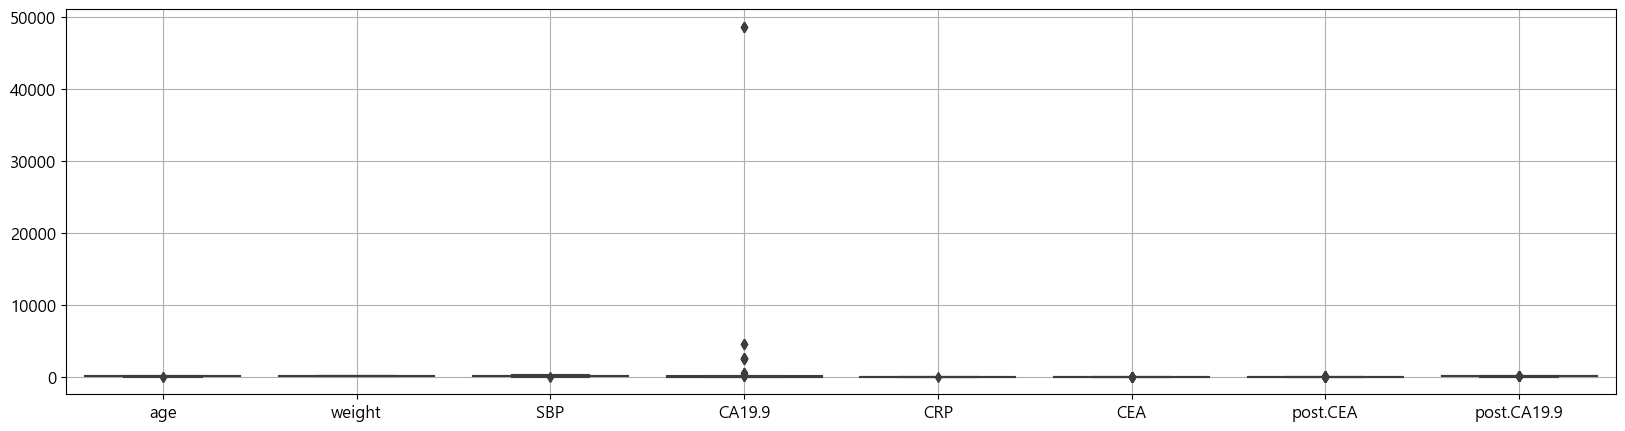

In [11]:
plt.figure(figsize=(20,5))
sb.boxplot(data=df)
plt.grid()
plt.show()
plt.close()

>"CA19.9"에서 약 50000정도의 값이 발견. 이상치인지 확인이 필요.

### 이상치 확인

In [12]:
df.query('`CA19.9`>40000')

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
63,60,1,80.024716,1,192.226734,48599.8,9.7,4.7,9.5,2,0,1,41.421145,1,2
115,61,1,74.031541,1,176.594650,48599.3,10.4,6.6,6.6,2,0,1,36.516956,0,1


>수치가 4만이 넘는 경우가 모두 췌장암 2기로 확인됨(stage==2)

In [13]:
# 췌장암이 2기인 CA19.9 데이터 추출
df.query('stage==2')

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
9,69,0,53.920287,1,108.237287,19.9,0.1,4.6,15.1,2,1,0,62.095475,1,2
10,39,1,64.035273,0,88.061020,84.2,9.6,4.3,6.1,2,1,0,50.118498,1,2
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
12,69,1,70.208801,1,163.587691,49.5,0.1,7.2,8.2,2,1,1,34.626853,0,1
23,64,1,82.150157,0,169.410154,67.3,3.5,1.8,0.9,2,1,0,34.890297,0,1
26,59,0,60.346471,0,121.918068,12.7,1.7,1.2,0.2,2,1,0,44.344380,1,2
27,41,0,53.729653,0,95.660858,7.6,0.1,8.3,19.4,2,1,1,34.043468,0,1
29,48,1,70.060164,0,108.765715,15.0,3.8,6.8,3.6,2,0,0,44.855612,1,2
30,34,1,71.468074,0,51.737041,49.6,3.9,4.2,1.5,2,0,0,43.407932,1,2


>다른 췌장암 2기와 비교했을 경우 큰 차이가 나므로 CA19.9 수치가 4만을 넘는 경우를 이상치로 판단하고 제거하기로 결정함.

### 이상치 정제

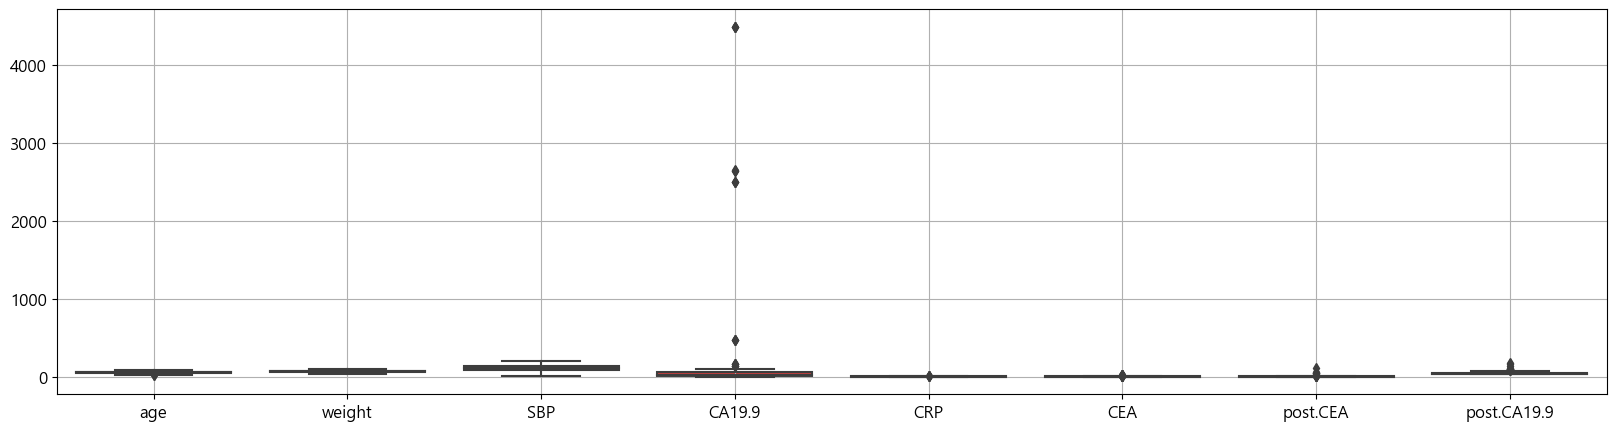

In [14]:
df2 = df.drop(df.query("`CA19.9` > 40000").index)

plt.figure(figsize=(20,5))
sb.boxplot(data=df2)
plt.grid()
plt.show()
plt.close()

## #05. 데이터셋 분할

### 랜덤시드 고정

In [15]:
np.random.seed(777)

### 훈련 데이터(독립), 레이블(종속) 구분

type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능

In [16]:
x = df2.drop(['Recur'], axis=1)
y = df2['Recur']

x.shape, y.shape

((153, 14), (153,))

> y는 1차원

### 데이터 표준화

명목형 변수는 더미변수로 변환해야 하므로 데이터를 종류별로 구분
- 연속형 변수
- 명목형 변수

#### 연속형 변수만 추출

In [17]:
# 카테고리 형식 제외 데이터
x1 = x.drop(['sex', 'stage', 'smoking', 'obesity', 'post.CA19.9.binary', 'post.CA19.9.3grp'], axis=1)
x1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          153 non-null    int64  
 1   weight       153 non-null    float64
 2   SBP          153 non-null    float64
 3   CA19.9       153 non-null    float64
 4   CRP          153 non-null    float64
 5   CEA          153 non-null    float64
 6   post.CEA     153 non-null    float64
 7   post.CA19.9  153 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 10.8 KB


#### 명목형 변수만 추출

In [18]:
x2 = x.filter(['sex', 'stage', 'smoking', 'obesity', 'post.CA19.9.binary', 'post.CA19.9.3grp'], axis=1)
x2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   sex                 153 non-null    category
 1   stage               153 non-null    category
 2   smoking             153 non-null    category
 3   obesity             153 non-null    category
 4   post.CA19.9.binary  153 non-null    category
 5   post.CA19.9.3grp    153 non-null    category
dtypes: category(6)
memory usage: 2.8 KB


#### 연속형 변수에 대한 표준화

In [19]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(x1)
x_scale_df = DataFrame(x_scale, index=x1.index, columns=x1.columns)
x_scale_df.head()

,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
id,,,,,,,,
1,1.963300,0.423063,0.786098,5.459243,-0.822126,-0.222609,-0.018407,-0.504152
2,-0.526293,-0.212338,-0.176862,-0.245568,-0.822126,-0.680266,-0.296946,-0.679230
3,-2.237888,-0.324186,-2.954433,-0.245568,-0.822126,1.632102,0.546406,-0.750126
4,-1.693289,-1.065587,0.776506,-0.209447,-0.473529,-0.632091,-0.382054,-0.532873
5,-0.604092,0.337996,1.551328,-0.243646,2.257144,-0.053999,-0.382054,-0.628984


#### 명목형 변수를 더미변수로 변환

데이터의 종류가 몇가지인지 확인.

데이터 엑셀파일에서 `stage`, `post.CA19.9.3grp` 필드만 값이 3종류로 확인.


`더미변수`는 `변수의 값이 최소 2개를 초과`할 경우 수행. 아니면 단순 category 타입으로 변경.

범주형(명목형) 데이터(카테고리가 1~3등급)를 각 카테고리별로 나누어 표현 - 명목형은 계산할 수 있는 값이 아니기 때문

ex) 태아의 성별, 위암 등급, 승무원의 등급

- 명목형으로 의심되면 일단 value_counts()로 확인.
- type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능.


***카테고리의 기준***

>탐색적 데이터 분석에서 사용하기 위해 카테고리화를 진행 - (단, 통계에서는 카테고리 형식으로 데이터를 분석하지 않고 int 형식으로 사용)

>정석대로라면 카테고리로 변경하지 않음. 
단, 탐색적 데이터 분석을 한다면 명목형 변수를 제거해야 하는데 명목형을 카테고리로 변경하면 자동으로 제거해주기 때문에 카테고리 형식으로 변환 후 진행. 

> category 대신 더미변수로 변경하면 int로 돌아오므로 더미변수화를 추천.

In [20]:
x2_dm = get_dummies(x2, columns=['stage', 'post.CA19.9.3grp'], drop_first=True, dtype='int')
x2_dm.head()

,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,
1,1,1,1,0,0,1,0,0
2,0,1,0,0,0,1,0,0
3,1,1,0,0,0,1,0,0
4,1,1,1,0,0,1,0,0
5,1,1,0,0,0,1,0,0


#### 연속형과 더미변수로 변환된 명목형을 결합

In [21]:
xdf = merge(x_scale_df, x2_dm, left_index=True, right_index=True)
print(xdf.shape)
xdf.head()

(153, 16)


,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,,,,,,,,,
1,1.963300,0.423063,0.786098,5.459243,-0.822126,-0.222609,-0.018407,-0.504152,1,1,1,0,0,1,0,0
2,-0.526293,-0.212338,-0.176862,-0.245568,-0.822126,-0.680266,-0.296946,-0.679230,0,1,0,0,0,1,0,0
3,-2.237888,-0.324186,-2.954433,-0.245568,-0.822126,1.632102,0.546406,-0.750126,1,1,0,0,0,1,0,0
4,-1.693289,-1.065587,0.776506,-0.209447,-0.473529,-0.632091,-0.382054,-0.532873,1,1,1,0,0,1,0,0
5,-0.604092,0.337996,1.551328,-0.243646,2.257144,-0.053999,-0.382054,-0.628984,1,1,0,0,0,1,0,0


#### 훈련 데이터와 검증 데이터로 분할

In [22]:
x_train, x_test, y_train, y_test = train_test_split(xdf, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((107, 16), (46, 16), (107,), (46,))

## #06. 모델 개발

### 모델 정의

> [`relu`], sigmoid, rmsporp, binary_crossentropy, acc

- input_shape은 독립변수 수
- Dense 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- activation은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- optimizer은 모르면 Adam
- epochs는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [23]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(16, )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [24]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500


4/4 [==============================] - 3s 455ms/step - loss: 0.7325 - acc: 0.4299 - val_loss: 0.7507 - val_acc: 0.4348 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 29ms/step - loss: 0.6924 - acc: 0.4766 - val_loss: 0.7381 - val_acc: 0.4565 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 62ms/step - loss: 0.6689 - acc: 0.5981 - val_loss: 0.7284 - val_acc: 0.5000 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 71ms/step - loss: 0.6484 - acc: 0.6168 - val_loss: 0.7193 - val_acc: 0.5000 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 58ms/step - loss: 0.6321 - acc: 0.6449 - val_loss: 0.7155 - val_acc: 0.4565 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 72ms/step - loss: 0.6198 - acc: 0.6355 - val_loss: 0.7104 - val_acc: 0.4348 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 37ms/step - loss: 0.6082 - acc: 0.6542 - val_loss: 0.7027 - val_acc: 0.4565 - lr: 0.0010
Epoch 8/50

## #07. 학습 결과 평가

>08-다중선형회귀(데이터프레임화, 손실률 시각화)참고

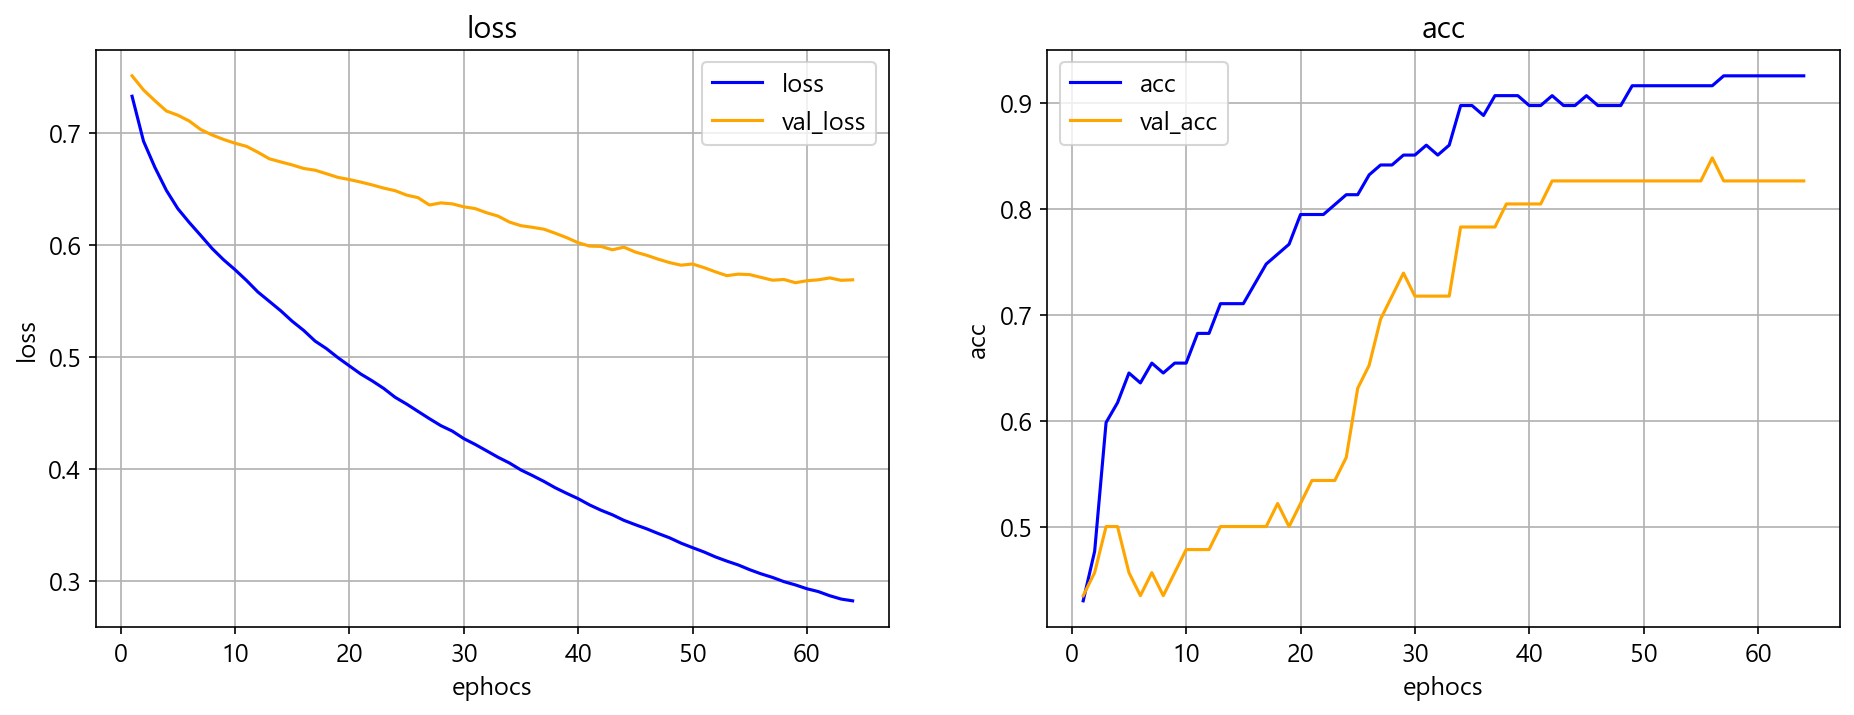

4/4 [==============================] - 0s 7ms/step - loss: 0.2802 - acc: 0.9346
최종 훈련 손실률: 0.280208, 최종 훈련 정확도: 0.934579
2/2 [==============================] - 0s 8ms/step - loss: 0.5686 - acc: 0.8261
최종 검증 손실률: 0.568601, 최종 검증 정확도: 0.826087


In [25]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

> 과적합이 발생할 경우 일단 데이터를 추가로 생성, 삽입

### 혼동행렬

In [26]:
logit_result = helper.tf_logit_result(model, result, x_train, y_train)
logit_result.cmdf

4/4 [==============================] - 0s 8ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


,Negative,Positive
True,46,6
False,1,54


## #08. 학습 결과 적용

### 예측 결과 산정

In [27]:
train_pred = model.predict(x_train)
train_pred

4/4 [==============================] - 0s 5ms/step


array([[0.96756595],
       [0.17522195],
       [0.1560653 ],
       [0.04167907],
       [0.37978968],
       [0.17935173],
       [0.95041156],
       [0.41673383],
       [0.875494  ],
       [0.36385363],
       [0.27230847],
       [0.615231  ],
       [0.29689315],
       [0.90300286],
       [0.23508789],
       [0.3621828 ],
       [0.89617455],
       [0.62253237],
       [0.9571852 ],
       [0.35319164],
       [0.9985448 ],
       [0.62839687],
       [0.99401814],
       [0.94231385],
       [0.20614025],
       [0.17073639],
       [0.19602868],
       [0.8038225 ],
       [0.95150286],
       [0.35583434],
       [0.29648468],
       [0.42616576],
       [0.2600109 ],
       [0.23117547],
       [0.50151193],
       [0.9944273 ],
       [0.7155875 ],
       [0.9874934 ],
       [0.85279495],
       [0.831874  ],
       [0.40047133],
       [0.9379839 ],
       [0.95478565],
       [0.91747135],
       [0.26023614],
       [0.36870787],
       [0.44966835],
       [0.958

In [28]:
test_pred = model.predict(x_test)
test_pred

2/2 [==============================] - 0s 4ms/step


array([[0.37108967],
       [0.9049375 ],
       [0.2620551 ],
       [0.2979729 ],
       [0.7779436 ],
       [0.18215403],
       [0.2543737 ],
       [0.6707252 ],
       [0.88981104],
       [0.3883647 ],
       [0.9521037 ],
       [0.8871433 ],
       [0.2564656 ],
       [0.3120244 ],
       [0.31859306],
       [0.3122213 ],
       [0.58341867],
       [0.28536773],
       [0.4305667 ],
       [0.3889625 ],
       [0.19053996],
       [0.30164486],
       [0.5345391 ],
       [0.5799107 ],
       [0.76637894],
       [0.28967667],
       [0.229922  ],
       [0.9206876 ],
       [0.5300871 ],
       [0.9875433 ],
       [0.87871885],
       [0.7200888 ],
       [0.9867908 ],
       [0.99943787],
       [0.7107402 ],
       [0.5881077 ],
       [0.28278738],
       [0.37617508],
       [0.78770334],
       [0.9821049 ],
       [0.2751595 ],
       [0.16002104],
       [0.15157436],
       [0.3584288 ],
       [0.9129634 ],
       [0.72737193]], dtype=float32)

### 결과 데이터 셋 구성

In [29]:
# 확률적으로 yes/no의 관계 -> 0/1로 표현
train_pred_bin = (train_pred.flatten() > 0.5).astype(int)
train_pred_bin

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1])

In [30]:
train_result_df = DataFrame({'y_train': y_train, 'train_pred': train_pred_bin})
train_result_df

,y_train,train_pred
id,,
126,1,1
155,0,0
133,0,0
134,0,0
103,0,0
...,...,...
74,1,1
90,0,0
61,1,0


In [31]:
train_result_df['result'] = train_result_df['y_train'] == train_result_df['train_pred']
train_result_df

,y_train,train_pred,result
id,,,
126,1,1,True
155,0,0,True
133,0,0,True
134,0,0,True
103,0,0,True
...,...,...,...
74,1,1,True
90,0,0,True
61,1,0,False


In [32]:
train_value_counts = train_result_df['result'].value_counts()
train_value_counts

result
True     100
False      7
Name: count, dtype: int64

In [33]:
test_pred_bin = (test_pred.flatten() > 0.5).astype(int)
test_result_df = DataFrame({'y_test': y_test, 'test_pred': test_pred_bin})
test_result_df['result'] = test_result_df['y_test'] == test_result_df['test_pred']
test_value_counts = test_result_df['result'].value_counts()
test_value_counts

result
True     38
False     8
Name: count, dtype: int64

In [34]:
result_df = DataFrame({
    'Train': [train_value_counts[True], train_value_counts[False]],
    'Test': [test_value_counts[True], test_value_counts[False]]
}, index=['Success', 'Fail'])

result_df

,Train,Test
Success,100,38
Fail,7,8


### 실제 결과값과 머신러닝에 의한 예측값 비교

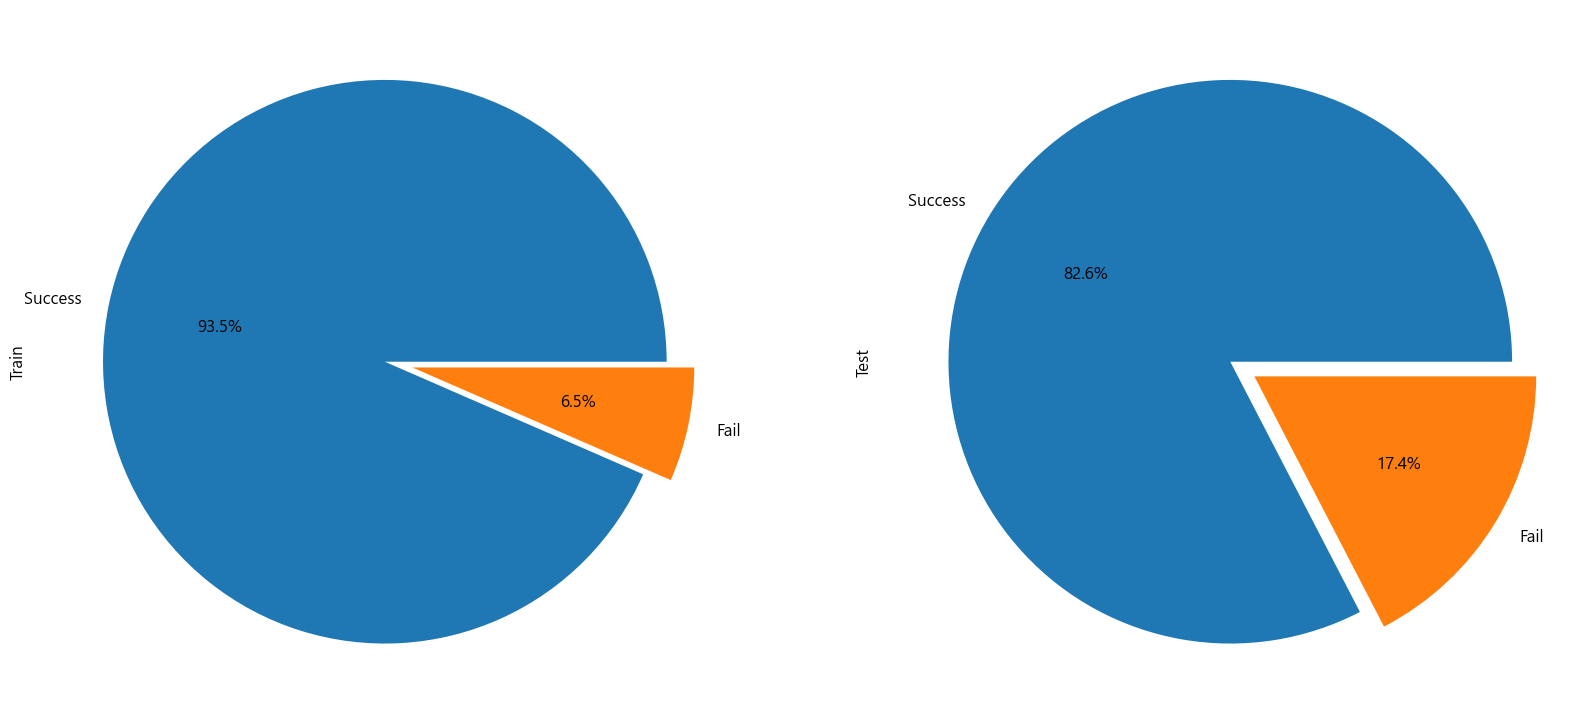

In [35]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

result_df['Train'].plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax1)
result_df['Test'].plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax2)

plt.show()
plt.close()